### 기본적으로 모든 조각들에 대한 컴포넌트화가 목적

In [15]:
import os
from pprint import pprint
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
from collections import Counter

#### 동일하거나 모두다른값 삭제 + OK -> NaN

In [16]:
def clean_and_save_train_data(train_data,root_dir, save_filename="cleaned_train_data.csv"):
    # 칼럼 리스트
    columns_to_clean = [
        'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
        'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1',
        'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'
    ]
    #------------------------
    #동일하거나 모두다른값 삭제
    #------------------------
    train_cleaned = train_data.dropna(axis=1, how='all')
    constant_columns = [col for col in train_cleaned.columns
                        if train_cleaned[col].nunique(dropna=False) == 1]

    all_unique_columns = [col for col in train_cleaned.columns
                          if train_cleaned[col].nunique() == len(train_cleaned)]
    train_cleaned = train_cleaned.drop(columns=constant_columns)
    train_cleaned = train_cleaned.drop(columns=all_unique_columns)
    #------------------------
    # OK->NaN 변환
    #------------------------
    def replace_ok_with_nan(column):
        return column.replace('OK', np.nan)

    for col in columns_to_clean:
        if col in train_cleaned.columns:
            train_cleaned[col] = replace_ok_with_nan(train_cleaned[col])
    #------------------------
    # 저장
    #------------------------
    # 5. Save the cleaned DataFrame
    #save_path = os.path.join(root_dir, save_filename)
    #train_cleaned.to_csv(save_path, index=False)

    #Equipment_Dam,Fill1,Fill2 공정에 대해서 인코딩 진행 
    dam_mapping = {
        'Dam dispenser #1': 1,
        'Dam dispenser #2': 2
    }

    fill1_mapping = {
    'Fill1 dispenser #1': 1,
    'Fill1 dispenser #2': 2
    }

    fill2_mapping = {
    'Fill2 dispenser #1': 1,
    'Fill2 dispenser #2': 2
    }

    # 매핑 적용하여 인코딩
    train_cleaned['Equipment_Dam'] = train_cleaned['Equipment_Dam'].map(dam_mapping)
    train_cleaned['Equipment_Fill1'] = train_cleaned['Equipment_Fill1'].map(fill1_mapping)
    train_cleaned['Equipment_Fill2'] = train_cleaned['Equipment_Fill2'].map(fill2_mapping)
    
    
    return train_cleaned

### 제거할 컬럼 목록

In [17]:
columns_to_drop = [
    'GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave',
    'CURE END POSITION X Collect Result_Dam',
    'CURE END POSITION Z Collect Result_Dam',
    'CURE END POSITION Θ Collect Result_Dam',
    'CURE START POSITION X Collect Result_Dam',
    'CURE END POSITION X Collect Result_Fill2',
    'CURE STANDBY POSITION Z Collect Result_Fill2',
    'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2',
    ]

#### OK 결측치 이후 뒤로 밀린값 앞으로 당기기

In [18]:
import pandas as pd
from tqdm import tqdm

def adjust_and_save_dataframe(train_data, root_dir, save_filename="cleaned.csv"):
    root_dir = "data"
    
    # 조건을 한 번에 계산
    cond16 = train_data.iloc[:, 16].isna()
    cond93 = train_data.iloc[:, 93].isna()
    cond126 = train_data.iloc[:, 126].isna()

    # tqdm을 사용하여 진행 상황 표시 (반복문 삭제)
    print("Adjusting DataFrame...")
    if any(cond16):
        train_data.loc[cond16, train_data.columns[16]] = train_data.loc[cond16, train_data.columns[18]]
        for i in tqdm(range(len(train_data.columns[18:68])), desc="Processing..."):
            train_data.loc[cond16, train_data.columns[18+i]] = train_data.loc[cond16, train_data.columns[19+i]]

    if any(cond93):
        train_data.loc[cond93, train_data.columns[93]] = train_data.loc[cond93, train_data.columns[95]]
        for i in tqdm(range(len(train_data.columns[95:115])), desc="Processing..."):
            train_data.loc[cond93, train_data.columns[95+i]] = train_data.loc[cond93, train_data.columns[96+i]]

    if any(cond126):
        train_data.loc[cond126, train_data.columns[126]] = train_data.loc[cond126, train_data.columns[128]]
        for i in tqdm(range(len(train_data.columns[128:148])), desc="Processing..."):
            train_data.loc[cond126, train_data.columns[128+i]] = train_data.loc[cond126, train_data.columns[129+i]]
    
    # 밀린 맨끝값들 없애기
    train_data.drop(columns=train_data.columns[[149, 116, 69]], inplace=True)

    return train_data


#### 통계량 확인

In [19]:
def calculate_statistics(dataframe):
    statistics = dataframe.describe()
    return statistics

#### 이상치, 결측치, Outlier

In [20]:
import numpy as np
from scipy import stats

def analyze_and_handle_missing_data(df):
    # nan확인
    nan_counts = df.isna().sum()
    nan_counts_with_nan = nan_counts[nan_counts > 0]

    # 결측치출력
    for column, count in nan_counts_with_nan.items():
        print(f"{column}: {count}개의 결측치")
        print(f"{column}: {df[column].dtype}")
        print(df[column].value_counts())  # Print non-NaN value counts

    # 결측치 평균으로 대체
    #for column in nan_counts_with_nan.index:
    #    if df[column].dtype in [np.float64, np.int64]:  # Only fill for numeric columns
    #        df[column].fillna(df[column].mean(), inplace=True)

    # outlier
    def detect_outliers_zscore(data):
        z_scores = np.abs(stats.zscore(data))
        return z_scores > 3

    for column in df.select_dtypes(include=[np.number]).columns:
        # Detect outliers using Z-score
        outliers_zscore = detect_outliers_zscore(df[column])
        print(f"Column {column} has {outliers_zscore.sum()} outliers detected by Z-score")
        # Histogram visualization
        #plt.figure(figsize=(10, 6))
        
        # Overall data histogram visualization
        #sns.histplot(df[column], kde=True, color='lightblue', label='Data', bins=30)
        
        # Outliers data histogram visualization
        #sns.histplot(df.loc[outliers_zscore, column], kde=True, color='red', label='Z-score Outliers', bins=30)
        
        #plt.title(f'Z-score Outliers Detection in {column}')
        #plt.legend()
        #plt.show()

    return df

# Example usage:
#cleaned_df = analyze_and_handle_missing_data(file_name)


#### 인코딩

#####  num_columns,columns_to_convert

In [21]:
# 숫자 데이터(int, float)로 이루어진 열 중 스케일링 대상
num_columns = [
    #'CURE END POSITION X Collect Result_Dam',
    #'CURE END POSITION Z Collect Result_Dam',
    #'CURE END POSITION Θ Collect Result_Dam',
    #'CURE START POSITION X Collect Result_Dam',
    'CURE START POSITION Θ Collect Result_Dam',
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam', 
    'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam',
    'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam',
    #'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam',
    #'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam',
    'HEAD Standby Position X Collect Result_Dam',
    'HEAD Standby Position Y Collect Result_Dam',
    'HEAD Standby Position Z Collect Result_Dam',
    'Head Clean Position X Collect Result_Dam',
    'Head Clean Position Y Collect Result_Dam',
    'Head Clean Position Z Collect Result_Dam',
    'Head Purge Position X Collect Result_Dam',
    'Head Purge Position Y Collect Result_Dam',
    'Head Purge Position Z Collect Result_Dam',
    'Head Zero Position X Collect Result_Dam',
    'Head Zero Position Y Collect Result_Dam',
    'Head Zero Position Z Collect Result_Dam',
    'PalletID Collect Result_Dam',
    'Receip No Collect Result_Dam',
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1', 
    'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1',
    #'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1',
    'HEAD Standby Position X Collect Result_Fill1',
    'HEAD Standby Position Y Collect Result_Fill1',
    'HEAD Standby Position Z Collect Result_Fill1',
    'Head Clean Position X Collect Result_Fill1',
    'Head Clean Position Y Collect Result_Fill1',
    'Head Clean Position Z Collect Result_Fill1',
    'Head Purge Position X Collect Result_Fill1',
    'Head Purge Position Y Collect Result_Fill1',
    'Head Purge Position Z Collect Result_Fill1',
    'PalletID Collect Result_Fill1',
    'Receip No Collect Result_Fill1',
    #'CURE END POSITION X Collect Result_Fill2',
    'CURE END POSITION Z Collect Result_Fill2',
    # 'CURE END POSITION Θ Collect Result_Fill2', 값이 모든 열 제거에서 제거됨이 확인
    #'CURE STANDBY POSITION Z Collect Result_Fill2',
    'CURE START POSITION X Collect Result_Fill2',
    'CURE START POSITION Z Collect Result_Fill2',
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2', 
    #'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2',
    #'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2',
    #'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2',
    #'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2',
    #'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2',
    #'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2',
    #'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2',
    #'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2',
    'HEAD Standby Position X Collect Result_Fill2',
    'HEAD Standby Position Y Collect Result_Fill2',
    'HEAD Standby Position Z Collect Result_Fill2',
    'Head Clean Position X Collect Result_Fill2',
    'Head Clean Position Y Collect Result_Fill2',
    'Head Clean Position Z Collect Result_Fill2',
    'Head Purge Position X Collect Result_Fill2',
    'Head Purge Position Y Collect Result_Fill2',
    'Head Purge Position Z Collect Result_Fill2',
    'PalletID Collect Result_Fill2',
    'Receip No Collect Result_Fill2',
    'Chamber Temp. Collect Result_AutoClave', 
]
columns_to_convert = [
        'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
        'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1',
        'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'
    ]

In [ ]:
#그 외 숫자 데이터(int, float)로 이루어진 열 ()
num_columns2 = [
    'CURE SPEED Collect Result_Dam',
    'DISCHARGED SPEED OF RESIN Collect Result_Dam', 
    'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam', 
    'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam', 
    'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam', 
    'Dispense Volume(Stage1) Collect Result_Dam', 
    'Dispense Volume(Stage2) Collect Result_Dam', 
    'Dispense Volume(Stage3) Collect Result_Dam', 
    'Machine Tact time Collect Result_Dam', 
    'Production Qty Collect Result_Dam', 
    'Stage1 Circle1 Distance Speed Collect Result_Dam', 
    'Stage1 Circle2 Distance Speed Collect Result_Dam', 
    'Stage1 Circle3 Distance Speed Collect Result_Dam', 
    'Stage1 Circle4 Distance Speed Collect Result_Dam', 
    'Stage1 Line1 Distance Speed Collect Result_Dam', 
    'Stage1 Line2 Distance Speed Collect Result_Dam', 
    'Stage1 Line3 Distance Speed Collect Result_Dam', 
    'Stage1 Line4 Distance Speed Collect Result_Dam', 
    'Stage2 Circle1 Distance Speed Collect Result_Dam', 
    'Stage2 Circle2 Distance Speed Collect Result_Dam', 
    'Stage2 Circle3 Distance Speed Collect Result_Dam', 
    'Stage2 Circle4 Distance Speed Collect Result_Dam', 
    'Stage2 Line1 Distance Speed Collect Result_Dam', 
    'Stage2 Line2 Distance Speed Collect Result_Dam', 
    'Stage2 Line3 Distance Speed Collect Result_Dam', 
    'Stage2 Line4 Distance Speed Collect Result_Dam', 
    'Stage3 Circle1 Distance Speed Collect Result_Dam', 
    'Stage3 Circle2 Distance Speed Collect Result_Dam', 
    'Stage3 Circle3 Distance Speed Collect Result_Dam', 
    'Stage3 Circle4 Distance Speed Collect Result_Dam', 
    'Stage3 Line1 Distance Speed Collect Result_Dam', 
    'Stage3 Line2 Distance Speed Collect Result_Dam', 
    'Stage3 Line3 Distance Speed Collect Result_Dam', 
    'Stage3 Line4 Distance Speed Collect Result_Dam', 
    'THICKNESS 1 Collect Result_Dam', 
    'THICKNESS 2 Collect Result_Dam', 
    'THICKNESS 3 Collect Result_Dam', 
    '1st Pressure Collect Result_AutoClave', 
    '1st Pressure 1st Pressure Unit Time_AutoClave', 
    '2nd Pressure Collect Result_AutoClave', 
    '2nd Pressure Unit Time_AutoClave', 
    '3rd Pressure Collect Result_AutoClave', 
    '3rd Pressure Unit Time_AutoClave', 
    'Chamber Temp. Unit Time_AutoClave', 
    'DISCHARGED SPEED OF RESIN Collect Result_Fill1', 
    'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1', 
    'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1', 
    'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1', 
    'Dispense Volume(Stage1) Collect Result_Fill1', 
    'Dispense Volume(Stage2) Collect Result_Fill1', 
    'Dispense Volume(Stage3) Collect Result_Fill1', 
    'Machine Tact time Collect Result_Fill1', 
    'Production Qty Collect Result_Fill1', 
    'CURE SPEED Collect Result_Fill2', 
    'Machine Tact time Collect Result_Fill2', 
    'Production Qty Collect Result_Fill2'
]

##### 이게 함수

In [22]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler

# OneHotEncoder 정의
encoder = OneHotEncoder(drop='first', sparse_output=False, dtype=int, handle_unknown='ignore')


def encode_and_transformation_train(df, num_columns=num_columns, columns_to_convert=columns_to_convert):
    # 1. 지정된 열들을 숫자형으로 변환
    for col in columns_to_convert:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # 2. Object 열들에 대한 인코딩 수행
    object_columns = df.select_dtypes(include=['object']).columns.tolist()
    # 라벨인코딩
    # label_encoders = {}
    # for col in object_columns:
    #     if col=="target":
    #         print("not Target Column.")
    #         continue
    #     le = LabelEncoder()
    #     df[col] = le.fit_transform(df[col].astype(str))
    #     label_encoders[col] = le
    
    # 원핫인코딩 - 위의 라벨 인코딩이랑 둘중 하나는 주석 걸어주셔야 합니다~
    columns_to_encode = [col for col in object_columns if col != 'target']

    # 원핫 인코딩 수행 (훈련 데이터에 맞추어 인코딩 수행)
    train_encoded = encoder.fit_transform(df[columns_to_encode])

    # 인코딩된 열의 이름을 가져옴 (OneHotEncoder는 자동으로 새로운 열 이름을 생성하지 않으므로 수동으로 관리해야 함)
    encoded_columns = encoder.get_feature_names_out(columns_to_encode)

    # DataFrame으로 변환
    train_cleaned_encoded = pd.DataFrame(train_encoded, columns=encoded_columns)

    # train_cleaned_encoded에 원래의 다른 열 추가
    train_cleaned_encoded = pd.concat([df.drop(columns=columns_to_encode).reset_index(drop=True), train_cleaned_encoded], axis=1)

    print("One-hot encoding completed.")

    # 3. 숫자형 열 정규화
    if num_columns:
        scaler = StandardScaler()
        train_cleaned_encoded[num_columns] = scaler.fit_transform(train_cleaned_encoded[num_columns])
    return train_cleaned_encoded, columns_to_encode, encoded_columns

def encode_and_transformation_test(df, columns_to_encode, encoded_columns, num_columns=num_columns, columns_to_convert=columns_to_convert):
    # 1. 지정된 열들을 숫자형으로 변환
    for col in columns_to_convert:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # test 데이터 원핫 인코딩
    test_encoded = encoder.transform(df[columns_to_encode])

    # DataFrame으로 변환
    test_data_encoded = pd.DataFrame(test_encoded, columns=encoded_columns)

    # test_data_encoded에 원래의 다른 열 추가
    test_data_encoded = pd.concat([df.drop(columns=columns_to_encode).reset_index(drop=True), test_data_encoded], axis=1)

    print("One-hot encoding completed.")

    # 3. 숫자형 열 정규화
    if num_columns:
        scaler = StandardScaler()
        test_data_encoded[num_columns] = scaler.fit_transform(test_data_encoded[num_columns])
    return test_data_encoded

#### 언더샘플링 함수

In [ ]:
import pandas as pd

def undersample_data(df, normal_ratio=1.0, random_state=None):
    # 정상 및 비정상 클래스를 분리
    df_normal = df[df["target"] == "Normal"]
    df_abnormal = df[df["target"] == "AbNormal"]

    # 각 클래스의 샘플 수를 확인
    num_normal = len(df_normal)
    num_abnormal = len(df_abnormal)
    
    print(f"Normal samples: {df_normal.shape}, AbNormal samples: {df_abnormal.shape}")
    print(f"Total: Normal: {num_normal}, AbNormal: {num_abnormal}")

    if num_abnormal == 0 or num_normal == 0:
        raise ValueError("One of the classes has no samples, check the data for issues.")
    
    # 정상 클래스를 비정상 클래스와 동일한 비율로 언더샘플링
    df_normal = df_normal.sample(n=int(num_abnormal * normal_ratio), replace=False, random_state=random_state)

    # 언더샘플링된 정상 클래스와 비정상 클래스를 결합
    df_balanced = pd.concat([df_normal, df_abnormal], axis=0).reset_index(drop=True)

    # 최종 통계 정보 출력
    num_normal_balanced = len(df_balanced[df_balanced["target"] == "Normal"])
    num_abnormal_balanced = len(df_balanced[df_balanced["target"] == "AbNormal"])
    print(f"Balanced data: Normal: {num_normal_balanced}, AbNormal: {num_abnormal_balanced}" + f" ratio: {num_abnormal_balanced/num_normal_balanced:.2f}")

    return df_balanced

# 사용 예시:
# df_balanced = undersample_data(train_cleaned_encoded, random_state=110)


#### 오버샘플링 함수

In [23]:
from imblearn.over_sampling import SMOTE
import pandas as pd

def oversample_data(df, normal_ratio=1.0, random_state=None):
    # 정상 및 비정상 클래스를 분리
    df_normal = df[df["target"] == "Normal"]
    df_abnormal = df[df["target"] == "AbNormal"]
    print(df["target"])
    
    # 각 클래스의 샘플 수를 확인
    num_normal = len(df_normal)
    num_abnormal = len(df_abnormal)
    
    print(f"Normal samples: {df_normal.shape}, AbNormal samples: {df_abnormal.shape}")
    print(f"Total: Normal: {num_normal}, AbNormal: {num_abnormal}")

    if num_abnormal == 0 or num_normal == 0:
        raise ValueError("One of the classes has no samples, check the data for issues.")
    
    # 오버샘플링: SMOTE를 사용하여 소수 클래스를 증강
    smote = SMOTE(sampling_strategy=normal_ratio, random_state=random_state)
    X = df.drop(columns=["target"])
    y = df["target"]
    
    X_resampled, y_resampled = smote.fit_resample(X, y)
    
    # 오버샘플링된 데이터를 다시 결합
    df_resampled = pd.concat([X_resampled, y_resampled], axis=1)
    
    # 통계 정보 출력 함수
    def print_stats(df: pd.DataFrame):
        num_normal = len(df[df["target"] == "Normal"])
        num_abnormal = len(df[df["target"] == "AbNormal"])
        print(f"Total: Normal: {num_normal}, AbNormal: {num_abnormal}" + f" ratio: {num_abnormal/num_normal:.2f}")

    print("Resampled data stats:")
    print_stats(df_resampled)

    return df_resampled

# 사용 예시:
# df_resampled = oversample_data(train_cleaned_encoded, random_state=110)

#### 전처리, 학습, 테스트데이터 예측함수

In [24]:
# 데이터 전처리 함수
def preprocess_data(train_data, test_data, ROOT_DIR):
    train_cleaned = clean_and_save_train_data(train_data, ROOT_DIR)
    test_cleaned = clean_and_save_train_data(test_data, ROOT_DIR)  
    print("Data cleaning completed")

    train_cleaned = adjust_and_save_dataframe(train_cleaned, ROOT_DIR)
    test_cleaned = adjust_and_save_dataframe(test_cleaned, ROOT_DIR)  
    print("Data adjustment completed")


    stats = calculate_statistics(train_cleaned)
    print("Statistics calculation completed")
    print(stats)

    train_encoded, columns_to_encode, encoded_columns = encode_and_transformation_train(train_cleaned)
    test_encoded = encode_and_transformation_test(test_cleaned, columns_to_encode, encoded_columns)  
    print("Data encoding and transformation completed")

    return train_encoded, test_encoded


In [25]:
# 모델 학습 함수
def train_model(df_train, RANDOM_STATE):
    model = RandomForestClassifier(
        bootstrap=True, 
        max_depth=None, 
        max_features='sqrt', 
        min_samples_leaf=1, 
        min_samples_split=10, 
        n_estimators=150, 
        random_state=42)
    
    features = []

    # 피처 선택 및 타입 변환
    for col in df_train.columns:
        try:
            df_train[col] = df_train[col].astype(int)
            features.append(col)
        except:
            continue

    train_x = df_train[features]
    train_y = df_train["target"]

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    accuracy_scores = cross_val_score(model, train_x, train_y, cv=skf, scoring='accuracy')
    f1_scores = cross_val_score(model, train_x, train_y, cv=skf, scoring='f1_macro')
    precision_scores = cross_val_score(model, train_x, train_y, cv=skf, scoring='precision_macro')

    print(f"정확도: {np.mean(accuracy_scores):.4f}")
    print(f"정밀도: {np.mean(precision_scores):.4f}")
    print(f"F1스코어: {np.mean(f1_scores):.4f}")
    print("Model training completed")

    # 모델 학습
    model.fit(train_x, train_y)
    return model, features

In [26]:
# 테스트 데이터 예측 및 결과 저장 함수
def predict_and_save_results(model, test_encoded, features):
    # 테스트 데이터 준비
    df_test_x = test_encoded[features]

    # 타입 변환
    for col in df_test_x.columns:
        try:
            df_test_x[col] = df_test_x[col].astype(int)
        except:
            continue

    # 테스트 데이터 예측
    test_pred = model.predict(df_test_x)
    print("Test data prediction completed")

    # Feature importance plot
    ftr_importances_values = model.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values, index=features)
    ftr_top30 = ftr_importances.sort_values(ascending=False)[:30]

    plt.figure(figsize=(8, 6))
    plt.title('Top 30 Feature Importances')
    sns.barplot(x=ftr_top30, y=ftr_top30.index)
    plt.show()
    print("Feature importance plotting completed")

    # Count predictions
    count = Counter(test_pred)
    for element, frequency in count.items():
        print(f'Element: {element}, Count: {frequency}')

    # Predict probabilities
    proba = model.predict_proba(df_test_x)
    print(proba)

    # 불량 케이스 추가 판별1
    col1 = 'Production Qty Collect Result_Dam'
    col2 = 'Production Qty Collect Result_Fill1'
    col3 = 'Production Qty Collect Result_Fill2'

    # 조건에 해당하는 행의 인덱스 찾기 (하나라도 다른 경우)
    abnormal_indices1 = df_test_x[(df_test_x[col1] != df_test_x[col2]) | 
                                  (df_test_x[col2] != df_test_x[col3]) | 
                                  (df_test_x[col1] != df_test_x[col3])].index

    # 해당 인덱스의 예측 결과를 'AbNormal'로 덮어쓰기
    for idx in abnormal_indices1:
        test_pred[idx] = 'AbNormal'

    # 불량 케이스 추가 판별2
    col4 = 'PalletID Collect Result_Dam'
    col5 = 'PalletID Collect Result_Fill1'
    col6 = 'PalletID Collect Result_Fill2'

    # 조건에 해당하는 행의 인덱스 찾기 (하나라도 다른 경우)
    abnormal_indices2 = df_test_x[(df_test_x[col4] != df_test_x[col5]) | 
                                  (df_test_x[col5] != df_test_x[col6]) | 
                                  (df_test_x[col4] != df_test_x[col6])].index

    # 해당 인덱스의 예측 결과를 'AbNormal'로 덮어쓰기
    for idx in abnormal_indices2:
        test_pred[idx] = 'AbNormal'

    # 불량 케이스 추가 판별3
    col7 = 'Receip No Collect Result_Fill1'
    col8 = 'Receip No Collect Result_Fill2'

    # 조건에 해당하는 행의 인덱스 찾기 (하나라도 다른 경우)
    abnormal_indices3 = df_test_x[(df_test_x[col7] != df_test_x[col8])].index
 
    # 해당 인덱스의 예측 결과를 'AbNormal'로 덮어쓰기
    for idx in abnormal_indices3:
        test_pred[idx] = 'AbNormal'

    # 불량 케이스 추가 판별4
    col9 = 'Equipment_Dam'
    col10 = 'Equipment_Fill1'
    col11 = 'Equipment_Fill2'


     # 조건에 해당하는 행의 인덱스 찾기 (하나라도 다른 경우)
    abnormal_indices4 = df_test_x[(df_test_x[col9] != df_test_x[col10]) | 
                                  (df_test_x[col10] != df_test_x[col11]) | 
                                  (df_test_x[col9] != df_test_x[col11])].index

        # 해당 인덱스의 예측 결과를 'AbNormal'로 덮어쓰기
    for idx in abnormal_indices4:
            test_pred[idx] = 'AbNormal'
    
       
    
    # 결과 저장
    df_sub = pd.read_csv("submission.csv")
    df_sub["target"] = test_pred
    df_sub.to_csv("submission.csv", index=False)
    print("Submission file saved")

    value_counts = df_sub['target'].value_counts()
    print(value_counts)

In [27]:
ROOT_DIR = "data"
RANDOM_STATE = 110

#데이터 전처리
train_data = pd.read_csv(os.path.join(ROOT_DIR, "train.csv"))
test_data = pd.read_csv(os.path.join(ROOT_DIR, "test.csv"))
print("Data loading completed")
print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")


train_encoded, test_encoded = preprocess_data(train_data, test_data, ROOT_DIR)

print(f"Encoded train data shape: {train_encoded.shape}")
print(f"Encoded test data shape: {test_encoded.shape}")


Data loading completed
Train data shape: (40506, 464)
Test data shape: (17361, 465)
Data cleaning completed


Adjusting DataFrame:   0%|          | 0/40506 [00:00<?, ?it/s]/var/folders/7p/6yk62ngn06b7t5kjjlv_kxyr0000gn/T/ipykernel_33381/604839580.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '114.612' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_data.iloc[i, 128:149] = temp_values[1:]
/var/folders/7p/6yk62ngn06b7t5kjjlv_kxyr0000gn/T/ipykernel_33381/604839580.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.012' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_data.iloc[i, 18:69] = temp_values[1:]
Adjusting DataFrame:   0%|          | 0/17361 [00:00<?, ?it/s]/var/folders/7p/6yk62ngn06b7t5kjjlv_kxyr0000gn/T/ipykernel_33381/604839580.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an err

Data adjustment completed
Statistics calculation completed
       Equipment_Dam  CURE SPEED Collect Result_Dam  \
count   40506.000000                   40506.000000   
mean        1.382067                      73.864119   
std         0.485899                       9.761997   
min         1.000000                      70.000000   
25%         1.000000                      70.000000   
50%         1.000000                      70.000000   
75%         2.000000                      70.000000   
max         2.000000                     105.000000   

       CURE START POSITION Θ Collect Result_Dam  \
count                              40506.000000   
mean                                 -21.227966   
std                                   87.461776   
min                                  -90.000000   
25%                                  -90.000000   
50%                                  -90.000000   
75%                                   90.000000   
max                                  

/opt/anaconda3/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1, 4, 8, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


One-hot encoding completed.
Data encoding and transformation completed
Encoded train data shape: (40506, 2797)
Encoded test data shape: (17361, 2796)


0          Normal
1          Normal
2          Normal
3          Normal
4          Normal
           ...   
40501      Normal
40502      Normal
40503      Normal
40504      Normal
40505    AbNormal
Name: target, Length: 40506, dtype: object
Normal samples: (38156, 2797), AbNormal samples: (2350, 2797)
Total: Normal: 38156, AbNormal: 2350
Resampled data stats:
Total: Normal: 38156, AbNormal: 38156 ratio: 1.00
Train set shape: (76312, 2797)
정확도: 0.9562
정밀도: 0.9565
F1스코어: 0.9562
Model training completed
Test data prediction completed


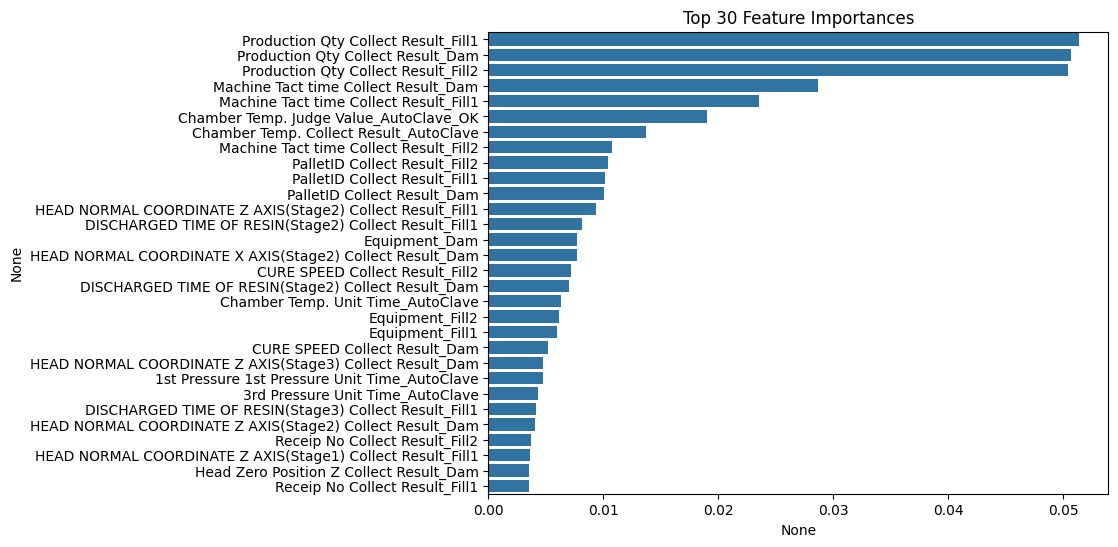

Feature importance plotting completed
Element: Normal, Count: 16743
Element: AbNormal, Count: 618
[[0.15169236 0.84830764]
 [0.14488335 0.85511665]
 [0.14665923 0.85334077]
 ...
 [0.2087852  0.7912148 ]
 [0.1164899  0.8835101 ]
 [0.09286889 0.90713111]]
Submission file saved
target
Normal      16727
AbNormal      634
Name: count, dtype: int64


In [28]:
# 모델 학습
df_train = oversample_data(train_encoded, random_state=RANDOM_STATE)

print(f"Train set shape: {df_train.shape}")

model, features = train_model(df_train, RANDOM_STATE)

# 테스트 데이터 예측 및 결과 저장
predict_and_save_results(model, test_encoded, features)
